##### EEEL 4220 Final Project
## Wind Farm Sizing and Siting on IEEE-14 System

4. 14-bus 5-scenario, with wind planning. Finally, assemble all scenarios together to produce the full planning model.

In [137]:
# Import libraries
# Model
import cvxpy as cp
import numpy as np
import pandas as pd
# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
# Load data
b_df = pd.read_csv('buses.csv')
g_df = pd.read_csv('generators.csv')
l_df = pd.read_csv('branches.csv')
d_df = pd.read_csv('demand_scenarios.csv')
cfs_df = pd.read_csv('wind_cf_scenarios.csv')
y_df = pd.read_csv('wind_candidates.csv')

In [139]:
# Parameters
c2 = g_df['c2'].to_numpy().reshape(-1,1) # quadratic cost coefficients for generator g
c1 = g_df['c1'].to_numpy().reshape(-1,1) # linear cost coefficients for generator g
c0 = g_df['c0'].to_numpy().reshape(-1,1) # fixed cost coefficients for generator g
Pmin = g_df['Pmin_MW'].to_numpy().reshape(-1,1) # minimum generation limits for generator g
Pmax = g_df['Pmax_MW'].to_numpy().reshape(-1,1) # maximum generation limits for generator g
x = l_df['x_pu'].to_numpy().reshape(-1,1) # reactance of transmission line l
fmax = l_df['rateA_MW'].to_numpy().reshape(-1,1) # thermal limit of line l
D = d_df.pivot(index='bus_id',columns='scenario_id',values='Pd_MW').to_numpy() # demand at bus b in scenario s
CF = cfs_df['capacity_factor'].to_numpy().reshape(1,-1) # wind capacity factor in scenario s
omega = cfs_df['probability'].to_numpy() # probability (weight) of scenario s
ybar = pd.merge(b_df, y_df, on='bus_id', how='left')['max_capacity_MW'].fillna(0).to_numpy().reshape(-1,1) # maximum installable wind capacity at bus b (0 if not candidate)
Cinv = np.arange(0.0,3.0,0.5) # investment cost per MW of installed wind capacity ($/MW)

# Decision variables
p = cp.Variable((len(g_df), len(cfs_df)), nonneg=True) # ps = power output of generator g under scenario s
f = cp.Variable((len(l_df), len(cfs_df))) # fs = power flow on line l under scenario s
theta = cp.Variable((len(b_df), len(cfs_df))) # thetas = voltage angle at bus b (radians)
w = cp.Variable((len(b_df), len(cfs_df)), nonneg=True) # ws = wind generation at bus b under scenario s
y = cp.Variable((len(b_df),1), nonneg=True) # installed wind capacity at bus b (MW)

In [140]:
# Initialize incidence matrices
# Generator–bus
# Ggb = 1 if generator g is connected to bus b, 0 otherwise.
G = np.zeros((len(g_df), len(b_df)))

# Line–bus
# Alb = 1 if bus b is the sending (“from”) end of line l, if bus b is the receiving (“to”) end of line l, 0 otherwise.
A = np.zeros((len(l_df), len(b_df)))

# Populate incidence matrices
# Generator–bus
for gen_index in range(len(g_df)):
    bus_id = g_df.loc[gen_index, 'bus_id']
    bus_index = bus_id - 1
    G[gen_index, bus_index] = 1

# Line–bus
for line_index in range(len(l_df)):
    from_bus_id = l_df.loc[line_index, 'from_bus']
    to_bus_id = l_df.loc[line_index, 'to_bus']
    from_bus_index = from_bus_id - 1
    to_bus_index = to_bus_id - 1
    A[line_index, from_bus_index] = 1
    A[line_index, to_bus_index] = -1

In [141]:
# Initialize results
ICT  = np.zeros(shape=(len(b_df), len(Cinv)))
CT = np.zeros(shape=(1,len(Cinv)))
MCT = np.zeros(shape=((len(b_df),len(cfs_df), len(Cinv))))
GT = np.zeros(shape=((len(g_df),len(cfs_df), len(Cinv)))) 
WT = np.zeros(shape=((len(b_df),len(cfs_df), len(Cinv))))
LT = np.zeros(shape=((len(l_df),len(cfs_df), len(Cinv))))

for c in range(len(Cinv)):
    # Define constraints
    # Initialize an empty constraint set
    con = [] 

    # power balance
    con.append((A.T @ f) + D == (G.T @ p) + w)

    # generator output limits
    con.append(p <= Pmax)  # maximum generation

    # set reference angle
    con.append(theta[0] == 0)

    # DC power flow
    con.append(f == (A @ theta) / x)

    # line flow limits
    con.append(f <= fmax)  # maximum line flow
    con.append(f >= -fmax)  # minimum line flow
    # wind generation limits
    con.append(w <= y @ CF)  # wind generation cannot exceed installed capacity

    # wind capacity limits
    con.append(y <= ybar)  # maximum installed capacity

    # Define objective function
    C = Cinv[c]
    obj = cp.Minimize(cp.sum(cp.multiply(c2, cp.square(p)) + cp.multiply(c1, p) + c0, axis=0) @ omega
                        + C * cp.sum(y))

    # Solve problem
    prob = cp.Problem(obj, con)
    prob.solve(solver = "HIGHS");
    
    # Store results
    ICT[:, c] = y.value.flatten()
    CT[0, c] = obj.value
    MCT[:, :, c] = con[0].dual_value
    GT[:, :, c] = p.value
    WT[:, :, c] = w.value
    LT[:, :, c] = f.value


,Cinv_0.0,Cinv_0.5,Cinv_1.0,Cinv_1.5,Cinv_2.0,Cinv_2.5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,150.0,150.0,108.8,13.6,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,120.0,120.0,98.9,20.1,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,200.0,179.8,108.8,47.1,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0


,Cinv_0.0,Cinv_0.5,Cinv_1.0,Cinv_1.5,Cinv_2.0,Cinv_2.5
0,161.9,455.0,695.5,827.7,839.9,839.9


Text(0.5, 1.0, 'Total Cost vs Wind Investment Cost')

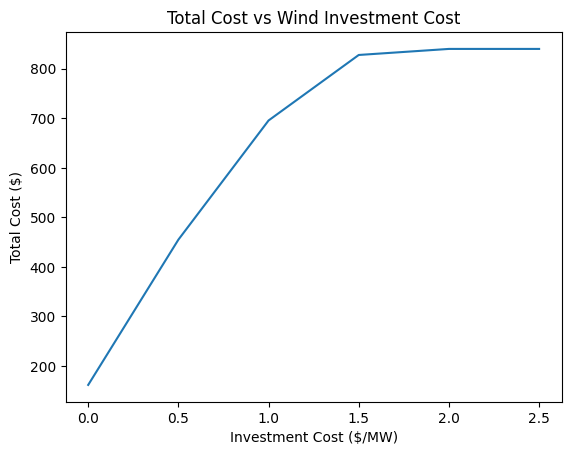

In [142]:
cols = [f'Cinv_{C}' for C in Cinv]

ICT_df = pd.DataFrame(ICT.round(1), columns=cols)
CT_df = pd.DataFrame(CT.round(1), columns=cols)
display(ICT_df)
display(CT_df)

plt.plot(Cinv.flatten(), CT_df.iloc[0,:])
plt.xlabel("Investment Cost ($/MW)")
# Set the y-axis label
plt.ylabel("Total Cost ($)")

# Add a title (optional)
plt.title("Total Cost vs Wind Investment Cost")

In [143]:
for i in [3,4,5]:
    display(ICT_df.iloc[[1,4,8,12],i].to_frame(name='Installed Capacity (MW)').set_axis(['B2','B5','B9','B13'], axis='index'))
    WT_df = pd.DataFrame(WT[[1,4,8,12],:,i].round(1), index=['B2','B5','B9','B13'], columns=['S1','S2','S3','S4','S5'])
    display(WT_df)
    GT_df = pd.DataFrame(GT[:,:,i].round(1), index=['G1','G2','G3','G4','G5'], columns=['S1','S2','S3','S4','S5'])
    display(GT_df)

,Installed Capacity (MW)
B2,13.6
B5,20.1
B9,47.1
B13,38.1


,S1,S2,S3,S4,S5
B2,2.7,4.8,6.8,2.0,8.2
B5,4.0,7.0,10.1,3.0,12.1
B9,9.4,16.5,23.6,7.1,28.3
B13,7.6,13.3,19.0,5.7,22.8


,S1,S2,S3,S4,S5
G1,70.5,73.4,76.3,77.3,67.4
G2,38.6,40.0,41.5,42.0,37.0
G3,38.3,40.1,41.8,42.4,36.4
G4,32.7,33.8,34.9,35.3,31.5
G5,29.2,30.0,30.9,31.2,28.2


,Installed Capacity (MW)
B2,0.0
B5,0.0
B9,0.0
B13,0.0


,S1,S2,S3,S4,S5
B2,0.0,0.0,0.0,0.0,0.0
B5,0.0,0.0,0.0,0.0,0.0
B9,0.0,0.0,0.0,0.0,0.0
B13,0.0,0.0,0.0,0.0,0.0


,S1,S2,S3,S4,S5
G1,79.1,88.4,97.8,83.8,93.1
G2,42.9,47.6,52.2,45.2,49.9
G3,43.5,49.1,54.7,46.3,51.9
G4,35.9,39.4,42.9,37.7,41.2
G5,31.7,34.5,37.3,33.1,35.9


,Installed Capacity (MW)
B2,0.0
B5,0.0
B9,0.0
B13,0.0


,S1,S2,S3,S4,S5
B2,0.0,0.0,0.0,0.0,0.0
B5,0.0,0.0,0.0,0.0,0.0
B9,0.0,0.0,0.0,0.0,0.0
B13,0.0,0.0,0.0,0.0,0.0


,S1,S2,S3,S4,S5
G1,79.1,88.4,97.8,83.8,93.1
G2,42.9,47.6,52.2,45.2,49.9
G3,43.5,49.1,54.7,46.3,51.9
G4,35.9,39.4,42.9,37.7,41.2
G5,31.7,34.5,37.3,33.1,35.9


/opt/anaconda3/envs/PyEnv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


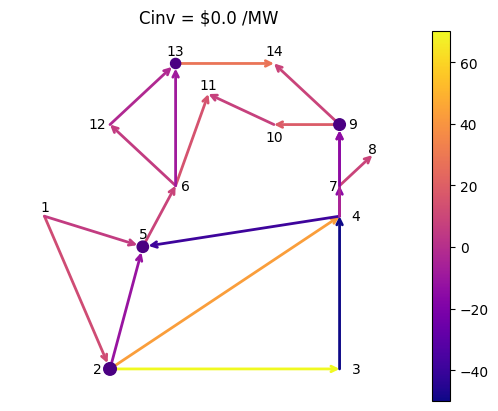

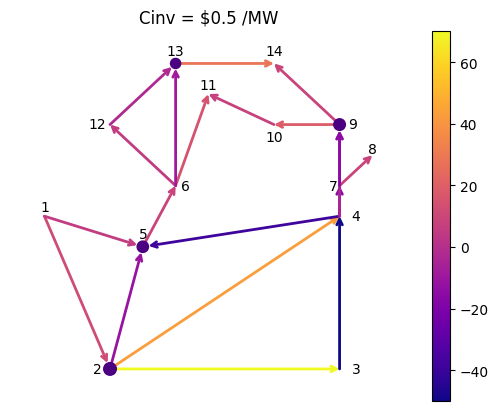

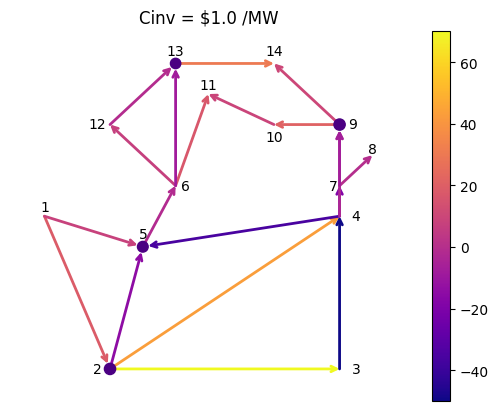

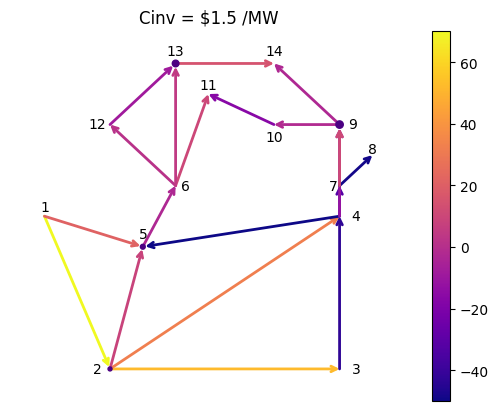

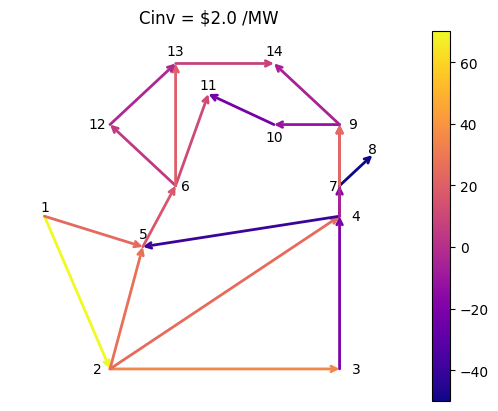

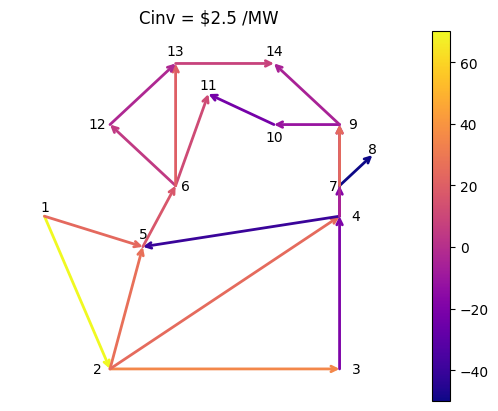

In [147]:
# Directed graph with node and edge weights
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

G.add_nodes_from(b_df['bus_id'].to_list())
G.add_edges_from(l_df[['from_bus', 'to_bus']].apply(tuple, axis=1).to_list())
pos = {
        1: (0, 5),
        2: (2, 0),
        3: (9, 0),
        4: (9, 5),
        5: (3, 4),
        6: (4, 6),
        7: (9, 6),
        8: (10, 7),
        9: (9, 8),
        10: (7, 8),
        11: (5, 9),
        12: (2, 8),
        13: (4, 10),
        14: (7, 10),
    }
pos_labels = {
        1: (0, 5.3),
        2: (1.6, 0),
        3: (9.5, 0),
        4: (9.5, 5),
        5: (3, 4.4),
        6: (4.3, 6),
        7: (8.8, 6),
        8: (10, 7.2),
        9: (9.4, 8),
        10: (7, 7.6),
        11: (5, 9.3),
        12: (1.6, 8),
        13: (4, 10.4),
        14: (7, 10.4),
    }

for c in range(1,7):
    node_sizes = WT[:,4,c-1].round(1) #[item *3 for item in d_df.loc[d_df['scenario_id'] == 5, 'Pd_MW'].to_list()]
    M = G.number_of_edges()
    edge_colors = LT[:,4,c-1].round(1)
    # edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    cmap = plt.cm.plasma

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo", cmap=cmap)
    labels = {node: str(node) for node in G.nodes()}
    labels = nx.draw_networkx_labels(G, pos_labels, labels, font_size=10, font_color='black')
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=2
    )
    # # set alpha value for each edge
    # # for i in range(M):
    # #     edges[i].set_alpha(edge_alphas[i])

    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)

    ax = plt.gca()
    ax.set_axis_off()
    pc.set_clim(vmin=-50, vmax=70)
    plt.colorbar(pc, ax=ax)
    plt.title("Cinv = $" + str((c-1)*0.5) + " /MW")
    plt.show()
